# Práctica Calificada 2 - Parte 2

Integrantes \
- Angelo Zevallos \
- Stefano Uccelli \
- Leonardo López \

# Librerías

In [ ]:
# Se importan las librerías que se van a utilizar
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import seaborn as sns
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings("ignore")
from google.colab import files
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
import itertools
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_absolute_error,confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, make_scorer
from scipy.stats import pearsonr

# 1. Preparación de los datos

(a) Seleccionamos las temporadas 2020/2021, 2021/2022 y 2022/2023, debido a que la conformación de los equipos, sea en jugadores o entrenadores, es propensa a cambiar si se considera un periodo muy amplio de tiempo. 
En vista que queremos predecir un resultado futuro, consideramos apropiado usar data más actual que reflejaría mejor las característias que el equipo en la siguiente champions league.


In [ ]:
# Se crea la data de predicción

Pred = {'HomeTeam': ['Leicester', 'Arsenal', 'Liverpool', 'Man City', 'Brighton'], 
        'AwayTeam': ['Everton', 'Chelsea', 'Fulham','West Ham', 'Man United'],
        'Date': ['1.5.23', '2.5.23', '3.5.23', '3.5.23', '4.5.23'],
        'Time': ['14:00', '14:00', '14:00', '14:00', '14:00']}
Pred = pd.DataFrame(Pred)
Pred['Pred'] = 1

In [ ]:
# Se descarga la data y se leen los datos
!curl -L -O https://www.football-data.co.uk/mmz4281/2223/E0.csv
df_ = pd.read_csv('E0.csv')
df_pl22 = df_.copy()

!curl -L -O https://www.football-data.co.uk/mmz4281/2122/E0.csv
df_ = pd.read_csv('E0.csv')
df_pl21 = df_.copy()

!curl -L -O https://www.football-data.co.uk/mmz4281/2021/E0.csv
df_ = pd.read_csv('E0.csv')
df_pl20 = df_.copy()

df_pl0 = pd.concat([df_pl22, df_pl21, df_pl20])
df_pl0 = df_pl0.reset_index(drop=True)

df_pl0['Pred'] = 0

df_pl = pd.concat([Pred, df_pl0])

df_pl.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146k  100  146k    0     0   196k      0 --:--:-- --:--:-- --:--:--  196k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  171k  100  171k    0     0   243k      0 --:--:-- --:--:-- --:--:--  242k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  171k  100  171k    0     0   240k      0 --:--:-- --:--:-- --:--:--  239k


,HomeTeam,AwayTeam,Date,Time,Pred,Div,FTHG,FTAG,FTR,HTHG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,Leicester,Everton,1.5.23,14:00,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arsenal,Chelsea,2.5.23,14:00,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Liverpool,Fulham,3.5.23,14:00,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Man City,West Ham,3.5.23,14:00,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Brighton,Man United,4.5.23,14:00,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(b) Eliminaremos las variables que 1. no aporten a la estimación a priori o que 2. esten altamente correlacionadas

In [ ]:
# 1. Revisamos las variables
'''
De lo visto en las variables, 
- Se elimina Div pues es la misma para todos
- Se elimina Referee por su naturaleza categórica que no consideramos útil
  dado que solo afectaría si el arbitro tiene algún sesgo Home o Away,
  pero sin saber que arbitro regirá el siguiente partido, no creemos que
  pueda ser empleado como predictor.
'''

'\nDe lo visto en las variables, \n- Se elimina Div pues es la misma para todos\n- Se elimina Referee por su naturaleza categórica que no consideramos útil\n  dado que solo afectaría si el arbitro tiene algún sesgo Home o Away,\n  pero sin saber que arbitro regirá el siguiente partido, no creemos que\n  pueda ser empleado como predictor.\n'

In [ ]:
# 2. Generamos la matrix de correlaciones
corrmat = round(df_pl0.corr(),2)
mask = np.tril(np.ones_like(corrmat, dtype=bool))
corrmat = corrmat*mask
corrmat = pd.DataFrame(corrmat)
print(corrmat)

'''
Dado que la matriz es muy grande es inconveniente graficarla, por lo que
optamos por descargar la matrix en un archivo local
'''

corrmat.to_csv('PL_corrmat.csv', index=False)

files.download('PL_corrmat.csv')

         FTHG  FTAG  HTHG  HTAG    HS    AS   HST   AST    HF    AF  ...  \
FTHG     1.00 -0.00  0.00 -0.00  0.00 -0.00  0.00 -0.00 -0.00 -0.00  ...   
FTAG    -0.13  1.00 -0.00  0.00 -0.00  0.00 -0.00  0.00 -0.00 -0.00  ...   
HTHG     0.71 -0.06  1.00 -0.00  0.00 -0.00  0.00 -0.00 -0.00 -0.00  ...   
HTAG    -0.08  0.70 -0.07  1.00 -0.00  0.00 -0.00  0.00 -0.00 -0.00  ...   
HS       0.36 -0.18  0.17 -0.08  1.00 -0.00  0.00 -0.00 -0.00 -0.00  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
MaxCAHH  0.01 -0.01 -0.01 -0.02  0.03 -0.03  0.04 -0.03 -0.02 -0.01  ...   
MaxCAHA  0.01  0.02 -0.00  0.02  0.00  0.04 -0.02  0.05 -0.05 -0.02  ...   
AvgCAHH  0.03 -0.07  0.01 -0.05  0.06 -0.08  0.07 -0.09  0.02 -0.01  ...   
AvgCAHA -0.04  0.06 -0.02  0.05 -0.07  0.09 -0.08  0.09 -0.01  0.01  ...   
Pred      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

         AHCh  B365CAHH  B365CAHA  PCAHH  PCAHA  MaxCAHH  MaxCAHA  AvgCAHH  \
FTHG    -

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Nos quedamos con el promedio de odds entre todas las casas de apuestas porque no hay una diferencia sustancial entre ellas
df_pl = df_pl.drop(columns=['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'MaxH', 'MaxD', 'MaxA'])
#Hacemos lo mismo para las probabildiades de tener más o menos de 2.5 goles
df_pl = df_pl.drop(columns=['B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5'])
df_pl = df_pl.drop(columns=['B365AHH', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA','B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'PSCH', 'PSCD', 'PSCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA'])
df_pl = df_pl.drop(columns=['Div', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA','B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5'])
df_pl = df_pl.drop(columns=['Referee'])

(c)

In [ ]:
#Se eliminan los empates
df_pl = df_pl[df_pl['FTR'] != 'D']
print(df_pl['FTR'].unique())

[nan 'A' 'H']


In [ ]:
# Eliminamos los equipos que no son relevantes para la predicción objetivo

teams_to_keep = ['Leicester City', 'Everton', 'Arsenal', 'Chelsea', 'Liverpool', 'Fulham', 'Man City', 'West Ham', 'Brighton', 'Man United']
df_pl = df_pl[df_pl['HomeTeam'].isin(teams_to_keep) | df_pl['AwayTeam'].isin(teams_to_keep)]
df_pl = df_pl.reset_index(drop=True)
df_pl

,HomeTeam,AwayTeam,Date,Time,Pred,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgAHH,AvgAHA,AvgCH,AvgCD,AvgCA,AvgC>2.5,AvgC<2.5,AHCh,AvgCAHH,AvgCAHA
0,Leicester,Everton,1.5.23,14:00,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arsenal,Chelsea,2.5.23,14:00,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Liverpool,Fulham,3.5.23,14:00,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Man City,West Ham,3.5.23,14:00,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Brighton,Man United,4.5.23,14:00,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,Fulham,Newcastle,23/05/2021,16:00,0,0.0,2.0,A,0.0,1.0,...,2.07,1.81,2.48,3.44,2.89,1.81,2.04,-0.25,2.12,1.77
579,Liverpool,Crystal Palace,23/05/2021,16:00,0,2.0,0.0,H,1.0,0.0,...,1.98,1.90,1.16,8.57,16.09,1.31,3.49,-2.25,1.88,2.00
580,Man City,Everton,23/05/2021,16:00,0,5.0,0.0,H,2.0,0.0,...,2.00,1.88,1.30,6.12,9.60,1.45,2.77,-1.75,2.03,1.85
581,West Ham,Southampton,23/05/2021,16:00,0,3.0,0.0,H,2.0,0.0,...,1.92,1.96,1.78,3.85,4.57,1.73,2.14,-0.75,1.99,1.89


In [ ]:
# Transformamos las variables tipo texto en numéricas
teams = ['Arsenal', 'Aston Villa', 'Wolves', "Nott'm Forest", 'Southampton',
       'Chelsea', 'Brighton', 'Man City', 'Everton', 'Leicester',
       'Bournemouth', 'Man United', 'West Ham', 'Brentford', 'Liverpool',
       'Leeds', 'Crystal Palace', 'Fulham', 'Tottenham', 'Newcastle',
       'Burnley', 'Norwich', 'Watford', 'West Brom', 'Sheffield United']

df_fin = df_pl.copy()

cat1 = pd.Categorical(df_pl['HomeTeam'], categories=teams)
df_fin['HomeTeam'] = cat1.codes

cat2 = pd.Categorical(df_pl['AwayTeam'], categories=teams)
df_fin['AwayTeam'] = cat2.codes

cat3 = pd.Categorical(df_pl['FTR'], categories=['A','H'])
df_fin['FTR'] = cat3.codes

cat4 = pd.Categorical(df_pl['HTR'], categories=['A','H'])
df_fin['HTR'] = cat4.codes

# Transformamos la variable Date a tipo fecha
df_fin['Date2'] = pd.to_datetime(df_fin['Date'])
df_fin = df_fin.drop('Date', axis=1)
df_fin = df_fin.rename(columns={'Date2': 'Date'})

# Transformamos la hora a numérica

df_fin[['hours', 'minutes']] = df_fin['Time'].str.split(':', expand=True).astype(float)
df_fin['Time'] = df_fin['hours']+df_fin['minutes']/60

# Generamos variable de temporada
def assign_season(date):
    if date < pd.to_datetime('2020-08-08'):
        return 0
    elif date >= pd.to_datetime('2020-08-08') and date <= pd.to_datetime('2021-05-29'):
        return 1
    elif date >= pd.to_datetime('2021-06-22') and date <= pd.to_datetime('2022-05-28'):
        return 2
    else:
        return 3

df_fin['Season'] = df_fin['Date'].apply(assign_season)

In [ ]:
df_fin

,HomeTeam,AwayTeam,Time,Pred,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgCA,AvgC>2.5,AvgC<2.5,AHCh,AvgCAHH,AvgCAHA,Date,hours,minutes,Season
0,9,8,14.0,1,NaN,NaN,-1,NaN,NaN,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-05,14.0,0.0,3
1,0,5,14.0,1,NaN,NaN,-1,NaN,NaN,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-02-05,14.0,0.0,3
2,14,17,14.0,1,NaN,NaN,-1,NaN,NaN,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-05,14.0,0.0,3
3,7,12,14.0,1,NaN,NaN,-1,NaN,NaN,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-05,14.0,0.0,3
4,6,11,14.0,1,NaN,NaN,-1,NaN,NaN,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-05,14.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,17,19,16.0,0,0.0,2.0,0,0.0,1.0,0,...,2.89,1.81,2.04,-0.25,2.12,1.77,2021-05-23,16.0,0.0,1
579,14,16,16.0,0,2.0,0.0,1,1.0,0.0,1,...,16.09,1.31,3.49,-2.25,1.88,2.00,2021-05-23,16.0,0.0,1
580,7,8,16.0,0,5.0,0.0,1,2.0,0.0,1,...,9.60,1.45,2.77,-1.75,2.03,1.85,2021-05-23,16.0,0.0,1
581,12,4,16.0,0,3.0,0.0,1,2.0,0.0,1,...,4.57,1.73,2.14,-0.75,1.99,1.89,2021-05-23,16.0,0.0,1


# 2. Feature engineering
(a)

In [ ]:
#Creamos nuevas variables
# Resultado del partido (Goles H - Goles A)
df_fin['RH'] = df_fin['FTHG']-df_fin['FTAG']
df_fin['RA'] = df_fin['FTAG']-df_fin['FTHG']
# Total de goles, tiros al arco y tiros de esquina
df_fin['TGAEH'] = df_fin['FTHG']+df_fin['HST']+df_fin['HC']
df_fin['TGAEA'] = df_fin['FTAG']+df_fin['AST']+df_fin['AC'] 
# La efectividad de los tiros y los tiros al arco HS/FTHG , HST/FTHG , AS/FTAG , AST/FTAG
df_fin['FTHG/HS'] = df_fin['FTHG'] / df_fin['HS']
df_fin['FTHG/HST'] = df_fin['FTHG'] / df_fin['HST']
df_fin['FTAG/AS'] = df_fin['FTAG'] / df_fin['AS']
df_fin['FTAG/AST'] = df_fin['FTAG'] / df_fin['AST']
# La proporcion de fauls que son tarjetas: HY/HF , HR/HF , AY/AF , AR/AF
df_fin['HY/HF'] = df_fin['HY'] / df_fin['HF']
df_fin['HR/HF'] = df_fin['HR'] / df_fin['HF']
df_fin['AY/AF'] = df_fin['AY'] / df_fin['AF']
df_fin['AR/AF'] = df_fin['AR'] / df_fin['AF']
# Log del promedio de las apuestas 'AvgH','AvgA','Avg>2.5', 'Avg<2.5',  'AvgAHH', 'AvgAHA'
df_fin['Log_AvgH'] = np.log(df_fin['AvgH'].mean())
df_fin['Log_AvgA'] = np.log(df_fin['AvgA'].mean())
df_fin['Log_Avg>2.5'] = np.log(df_fin['Avg>2.5'].mean())
df_fin['Log_Avg<2.5'] = np.log(df_fin['Avg<2.5'].mean())
df_fin['Log_AvgAHH'] = np.log(df_fin['AvgAHH'].mean())
df_fin['Log_AvgAHA'] = np.log(df_fin['AvgAHA'].mean())
# Exponencial de los goles 'FTHG', 'FTAG', 'HTHG', 'HTAG'
df_fin['Exp_FTHG'] = np.exp(df_fin['FTHG'])
df_fin['Exp_FTAG'] = np.exp(df_fin['FTAG'])
df_fin['Exp_HTHG'] = np.exp(df_fin['HTHG'])
df_fin['Exp_HTAG'] = np.exp(df_fin['HTAG'])



In [ ]:
df_fin

,HomeTeam,AwayTeam,Time,Pred,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,Log_AvgH,Log_AvgA,Log_Avg>2.5,Log_Avg<2.5,Log_AvgAHH,Log_AvgAHA,Exp_FTHG,Exp_FTAG,Exp_HTHG,Exp_HTAG
0,9,8,14.0,1,NaN,NaN,-1,NaN,NaN,-1,...,1.178426,1.635133,0.584899,0.762559,0.660527,0.663446,NaN,NaN,NaN,NaN
1,0,5,14.0,1,NaN,NaN,-1,NaN,NaN,-1,...,1.178426,1.635133,0.584899,0.762559,0.660527,0.663446,NaN,NaN,NaN,NaN
2,14,17,14.0,1,NaN,NaN,-1,NaN,NaN,-1,...,1.178426,1.635133,0.584899,0.762559,0.660527,0.663446,NaN,NaN,NaN,NaN
3,7,12,14.0,1,NaN,NaN,-1,NaN,NaN,-1,...,1.178426,1.635133,0.584899,0.762559,0.660527,0.663446,NaN,NaN,NaN,NaN
4,6,11,14.0,1,NaN,NaN,-1,NaN,NaN,-1,...,1.178426,1.635133,0.584899,0.762559,0.660527,0.663446,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,17,19,16.0,0,0.0,2.0,0,0.0,1.0,0,...,1.178426,1.635133,0.584899,0.762559,0.660527,0.663446,1.000000,7.389056,1.000000,2.718282
579,14,16,16.0,0,2.0,0.0,1,1.0,0.0,1,...,1.178426,1.635133,0.584899,0.762559,0.660527,0.663446,7.389056,1.000000,2.718282,1.000000
580,7,8,16.0,0,5.0,0.0,1,2.0,0.0,1,...,1.178426,1.635133,0.584899,0.762559,0.660527,0.663446,148.413159,1.000000,7.389056,1.000000
581,12,4,16.0,0,3.0,0.0,1,2.0,0.0,1,...,1.178426,1.635133,0.584899,0.762559,0.660527,0.663446,20.085537,1.000000,7.389056,1.000000


(b) La predicción de partidos de fútbol de asociación se ha vuelto cada vez más popular en los últimos años, se han propuesto distintos enfoques diferentes modelos de predicción con el objetivo de evaluar los atributos que llevaban a un equipo de fútbol a perder, empatar o ganar el partido. Se han llegado a considerar tres distintos enfoques para dichas predicciones; enfoques estadísticos, enfoque de Machine Learning y enfoques bayesianos (Razali, et al, 2017).

Stübinger (2019) explora la construcción de otras variables predictoras para mejorar la precisión de sus predicciones. Utilizan diferentes fuentes de datos para construir características relacionadas con el rendimiento del equipo en partidos anteriores, la características de los jugadores y sus habilidades de manera individual y las cuotas de apuestas. Además, los autores utilizan información geográfica y de clima para construir características relacionadas con la distancia recorrida por los equipos para el partido y la temperatura durante el partido.

Por su parte, otros modelos de Machine Learning consideran, además de los datos recopilados sobre partidos de fútbol, características individuales de los jugadores, como precisión de pase, agilidad, reacción, agresividad, así como información estadística sobre la calidad de los equipos de fútbol. Rodriguez & Pinto (2022) incluye nuevas variables para predecir mejor el resultado final de los partidos, crearon las variables promedio de goles recibidos en casa por el equipo local y promedio de goles recibidos fuera de casa por el equipo visitante. Asimismo se transformaron los datos ya que para la prediccion se deben usar datos ex-ante por lo que se tuvo que calculo la media para cada partido y cada equipo de los siguientes atributos: número de goles marcados, lanzamientos, tiros a puerta, numero de corners, número de faltas cometidas, número de tarjetas.

Baboota & Harleen (2018) precisan como posibles buenos predictores los resultados pasados, goles a favor y en contra, y el promedio de goles, tiros de esquina y al arco en k (estimación 5) semanas hacia atrás. Remarcan la utilidad de estos como medida del desempeño del equipo en los últimos partidos. El problema de esto es que no favorecería la aplicación de predicciones en las primeras semanas, pues no se tendría datos. Sus resultados finales no lograron sobrepasar las predicciones de las casas de apuestas. No obstante, consideramos apropiado incluir estos predictores en el modelo.

In [ ]:
#Features agregados:

ma_0 = df_fin.copy()
ma_0 = ma_0.sort_values('Date')

# Partidos Jugados en la temporada ---------------------------------------------
df_fin = df_fin.sort_values('Date')

df_fin['PJH'] = 0
df_fin['PJA'] = 0

num_partidos = {}

for index, row in df_fin.iterrows():

    equipo_local = row['HomeTeam']
    equipo_visitante = row['AwayTeam']

    temporada = row['Season']
    fecha = row['Date']

    # Incrementar el número de partidos jugados por cada equipo en la temporada actual
    if temporada not in num_partidos:
        num_partidos[temporada] = {}
    if equipo_local not in num_partidos[temporada]:
        num_partidos[temporada][equipo_local] = 0
    if equipo_visitante not in num_partidos[temporada]:
        num_partidos[temporada][equipo_visitante] = 0
    num_partidos[temporada][equipo_local] += 1
    num_partidos[temporada][equipo_visitante] += 1

    # Actualizar el número de partidos jugados por cada equipo
    df_fin.at[index, 'PJH'] = num_partidos[temporada][equipo_local]
    df_fin.at[index, 'PJA'] = num_partidos[temporada][equipo_visitante]


# Media móvil 6 partidos -------------------------------------------------------
variablesH = ['FTHG', 'HTHG', 'HS', 'HST', 'HF', 'HC', 'HY', 'HR', 'AvgH', 
             'AvgAHH', 'AvgCH', 'AvgCAHH', 'FTHG/HS', 'FTHG/HST', 'HY/HF',
             'HR/HF', 'Log_AvgH', 'Log_AvgAHH', 'Exp_FTHG', 
             'Exp_HTHG']

variablesA = ['FTAG', 'HTAG', 'AS', 'AST', 'AF', 'AC', 'AY', 'AR', 'AvgA', 
             'AvgAHA', 'AvgCA', 'AvgCAHA', 'FTAG/AS', 'FTAG/AST', 'AY/AF', 
             'AR/AF', 'Log_AvgA', 'Log_AvgAHA', 'Exp_FTAG', 
             'Exp_HTAG']

ma_0 = df_fin.copy()
ma_0 = ma_0.sort_values('Date')
i = 0

for col in variablesH:
  i += 1
  exec("ma6_"+ str(i) + "=" + "ma_0"+".groupby(['HomeTeam', 'Season']).rolling(window=6, on='Date')['"+col+"'].mean().reset_index()")

  exec("ma6_"+ str(i) + "=" + "ma6_"+ str(i)+".rename(columns={'"+col+"': 'Ma6_"+col+"'})")
  exec("ma6_"+ str(i) + "=" + "ma6_"+ str(i)+".rename(columns={'"+col+"': 'Ma6_"+col+"'})")

  exec("ma6_"+str(i)+"['Ma6_"+col+"'] = ma6_"+str(i)+".groupby(['HomeTeam', 'Season'])['Ma6_"+col+"'].shift(1)")
  exec("df_fin = pd.merge(df_fin, "+"ma6_"+str(i)+", on=['HomeTeam', 'Season', 'Date'])")

i = 0  
for col in variablesA:
  i += 1
  exec("ma6_"+ str(i) + "=" + "ma_0"+".groupby(['AwayTeam', 'Season']).rolling(window=6, on='Date')['"+col+"'].mean().reset_index()")

  exec("ma6_"+ str(i) + "=" + "ma6_"+ str(i)+".rename(columns={'"+col+"': 'Ma6_"+col+"'})")
  exec("ma6_"+ str(i) + "=" + "ma6_"+ str(i)+".rename(columns={'"+col+"': 'Ma6_"+col+"'})")

  exec("ma6_"+str(i)+"['Ma6_"+col+"'] = ma6_"+str(i)+".groupby(['AwayTeam', 'Season'])['Ma6_"+col+"'].shift(1)")
  exec("df_fin = pd.merge(df_fin, "+"ma6_"+str(i)+", on=['AwayTeam', 'Season', 'Date'])")

for col in variablesH:
  exec("df_fin['Ma6_"+col+"'] = np.where(df_fin['PJH'] < 7, np.nan, df_fin['Ma6_"+col+"'])")
 
for col in variablesA:
  exec("df_fin['Ma6_"+col+"'] = np.where(df_fin['PJA'] < 7, np.nan, df_fin['Ma6_"+col+"'])")

# Media móvil 1 partidos -------------------------------------------------------

i = 0
for col in variablesH:
  i += 1
  exec("ma1_"+ str(i) + "=" + "ma_0"+".groupby(['HomeTeam', 'Season']).rolling(window=1, on='Date')['"+col+"'].mean().reset_index()")

  exec("ma1_"+ str(i) + "=" + "ma1_"+ str(i)+".rename(columns={'"+col+"': 'Ma1_"+col+"'})")
  exec("ma1_"+ str(i) + "=" + "ma1_"+ str(i)+".rename(columns={'"+col+"': 'Ma1_"+col+"'})")

  exec("ma1_"+str(i)+"['Ma1_"+col+"'] = ma1_"+str(i)+".groupby(['HomeTeam', 'Season'])['Ma1_"+col+"'].shift(1)")
  exec("df_fin = pd.merge(df_fin, "+"ma1_"+str(i)+", on=['HomeTeam', 'Season', 'Date'])")

i = 0  
for col in variablesA:
  i += 1
  exec("ma1_"+ str(i) + "=" + "ma_0"+".groupby(['AwayTeam', 'Season']).rolling(window=1, on='Date')['"+col+"'].mean().reset_index()")

  exec("ma1_"+ str(i) + "=" + "ma1_"+ str(i)+".rename(columns={'"+col+"': 'Ma1_"+col+"'})")
  exec("ma1_"+ str(i) + "=" + "ma1_"+ str(i)+".rename(columns={'"+col+"': 'Ma1_"+col+"'})")

  exec("ma1_"+str(i)+"['Ma1_"+col+"'] = ma1_"+str(i)+".groupby(['AwayTeam', 'Season'])['Ma1_"+col+"'].shift(1)")
  exec("df_fin = pd.merge(df_fin, "+"ma1_"+str(i)+", on=['AwayTeam', 'Season', 'Date'])")

for col in variablesH:
  exec("df_fin['Ma1_"+col+"'] = np.where(df_fin['PJH'] < 2, np.nan, df_fin['Ma1_"+col+"'])")
 
for col in variablesA:
  exec("df_fin['Ma1_"+col+"'] = np.where(df_fin['PJA'] < 2, np.nan, df_fin['Ma1_"+col+"'])")

In [ ]:
#Función para calcular los puntos de la temporada
def calculate_points(row):
    if row['FTR'] == 'H':
        return pd.Series([3, 0])
    elif row['FTR'] == 'A':
        return pd.Series([0, 3])
    else:
        return pd.Series([1, 1])

df_fin[['HomePoints', 'AwayPoints']] = df_fin.apply(calculate_points, axis=1)
home_team_avg_points = df_fin.groupby('HomeTeam')['HomePoints'].mean()
away_team_avg_points = df_fin.groupby('AwayTeam')['AwayPoints'].mean()

In [ ]:
#Promedios simples
df = df_fin.copy()

home_team_avg_goals_season = df.groupby(['Season', 'HomeTeam'])['FTHG'].mean()
away_team_avg_goals_season = df.groupby(['Season', 'AwayTeam'])['FTAG'].mean()
home_team_avg_goals_conceded_season = df.groupby(['Season', 'HomeTeam'])['FTAG'].mean()
away_team_avg_goals_conceded_season = df.groupby(['Season', 'AwayTeam'])['FTHG'].mean()
home_team_avg_points_season = df.groupby(['Season', 'HomeTeam'])['HomePoints'].mean()
away_team_avg_points_season = df.groupby(['Season', 'AwayTeam'])['AwayPoints'].mean()
home_team_avg_ht_goals_season = df.groupby(['Season', 'HomeTeam'])['HTHG'].mean()
away_team_avg_ht_goals_season = df.groupby(['Season', 'AwayTeam'])['HTAG'].mean()

#creamos la matriz de promedios
Avg = pd.DataFrame({'Season': df['Season'], 'HomeTeam': df['HomeTeam'], 'AwayTeam': df['AwayTeam'],
                         'HomeTeamAvgGoals': df.apply(lambda x: home_team_avg_goals_season.loc[x['Season'], x['HomeTeam']], axis=1),
                         'AwayTeamAvgGoals': df.apply(lambda x: away_team_avg_goals_season.loc[x['Season'], x['AwayTeam']], axis=1),
                         'HomeTeamAvgGoalsConceded': df.apply(lambda x: home_team_avg_goals_conceded_season.loc[x['Season'], x['HomeTeam']], axis=1),
                         'AwayTeamAvgGoalsConceded': df.apply(lambda x: away_team_avg_goals_conceded_season.loc[x['Season'], x['AwayTeam']], axis=1),
                         'HomeTeamAvgPoints': df.apply(lambda x: home_team_avg_points_season.loc[x['Season'], x['HomeTeam']], axis=1),
                         'AwayTeamAvgPoints': df.apply(lambda x: away_team_avg_points_season.loc[x['Season'], x['AwayTeam']], axis=1),
                         'HomeTeamAvgHTGoals': df.apply(lambda x: home_team_avg_ht_goals_season.loc[x['Season'], x['HomeTeam']], axis=1),
                         'AwayTeamAvgHTGoals': df.apply(lambda x: away_team_avg_ht_goals_season.loc[x['Season'], x['AwayTeam']], axis=1)})

df_fin['HomeTeamAvgGoals'] = Avg['HomeTeamAvgGoals']
df_fin['AwayTeamAvgGoals'] = Avg['AwayTeamAvgGoals']
df_fin['AwayTeamAvgGoalsConceded'] = Avg['HomeTeamAvgGoalsConceded']
df_fin['AwayTeamAvgGoalsConceded'] = Avg['AwayTeamAvgGoalsConceded']
df_fin['HomeTeamAvgPoints'] = Avg['HomeTeamAvgPoints']
df_fin['HomeTeamAvgPoints'] = Avg['HomeTeamAvgPoints']
df_fin['HomeTeamAvgHTGoals'] = Avg['HomeTeamAvgHTGoals']
df_fin['HomeTeamAvgHTGoals'] = Avg['HomeTeamAvgHTGoals']

In [ ]:
# Baboota & Harleen (2018) -----------------------------------------------------

# Media movil resultado - últimos 6 partidos previos
ma_1 = ma_0.groupby(['HomeTeam', 'Season']).rolling(window=6, on='Date')['RH'].mean().reset_index()
ma_2 = ma_0.groupby(['AwayTeam', 'Season']).rolling(window=6, on='Date')['RA'].mean().reset_index()

ma_1 = ma_1.rename(columns={'RH': 'Ma_RH'})
ma_2 = ma_2.rename(columns={'RA': 'Ma_RA'})

ma_1['Ma_RH'] = ma_1.groupby(['HomeTeam', 'Season'])['Ma_RH'].shift(1)
ma_2['Ma_RA'] = ma_2.groupby(['AwayTeam', 'Season'])['Ma_RA'].shift(1)

# Media movil goles, tiros al arco y tiros de esquina - últimos 6 partidos previos

ma_3 = ma_0.groupby(['HomeTeam', 'Season']).rolling(window=6, on='Date')['TGAEH'].mean().reset_index()
ma_4 = ma_0.groupby(['AwayTeam', 'Season']).rolling(window=6, on='Date')['TGAEA'].mean().reset_index()

ma_3 = ma_3.rename(columns={'TGAEH': 'Ma_TGAEH'})
ma_4 = ma_4.rename(columns={'TGAEA': 'Ma_TGAEA'})

ma_3['Ma_TGAEH'] = ma_3.groupby(['HomeTeam', 'Season'])['Ma_TGAEH'].shift(1)
ma_4['Ma_TGAEA'] = ma_4.groupby(['AwayTeam', 'Season'])['Ma_TGAEA'].shift(1)

# Forma del equipo

  # Crear una columna "Partidos_Jugados"
df_fin['PJH'] = 0
df_fin['PJA'] = 0

num_partidos = {}

for index, row in df_fin.iterrows():

    equipo_local = row['HomeTeam']
    equipo_visitante = row['AwayTeam']

    temporada = row['Season']
    fecha = row['Date']

    # Incrementar el número de partidos jugados por cada equipo en la temporada actual
    if temporada not in num_partidos:
        num_partidos[temporada] = {}
    if equipo_local not in num_partidos[temporada]:
        num_partidos[temporada][equipo_local] = 0
    if equipo_visitante not in num_partidos[temporada]:
        num_partidos[temporada][equipo_visitante] = 0
    num_partidos[temporada][equipo_local] += 1
    num_partidos[temporada][equipo_visitante] += 1

    # Actualizar el número de partidos jugados por cada equipo
    df_fin.at[index, 'PJH'] = num_partidos[temporada][equipo_local]
    df_fin.at[index, 'PJA'] = num_partidos[temporada][equipo_visitante]

  # Calcular el feature
    # Ordenar el DataFrame por fecha
df_fin = df_fin.sort_values('Date')

season_scores = {}

# Puntuación base
df_fin['FH'] = 0.0
df_fin['FA'] = 0.0

# Iterar por fila para actualizar puntaje
for index, row in df_fin.iterrows():

    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    
    # Verificar si es el primer partido de la temporada para cada equipo
    if row['PJH']==1:
        season_scores[home_team] = 1.0
    if row['PJA']==1:
        season_scores[away_team] = 1.0
    
    # Actualizar según el resultado del partido
    if row['FTR']==1:
        season_scores[home_team] += 0.33*season_scores[away_team]
        season_scores[away_team] -= 0.33*season_scores[away_team]
    elif row['FTR']==0:
        season_scores[away_team] += 0.33*season_scores[home_team]
        season_scores[home_team] -= 0.33*season_scores[home_team]
  
    df_fin.at[index, 'FH'] = season_scores[home_team]
    df_fin.at[index, 'FA'] = season_scores[away_team]

# Terminar de unir la base de datos
df_fin = pd.merge(df_fin, ma_1, on=['HomeTeam', 'Season','Date'])
df_fin = pd.merge(df_fin, ma_2, on=['AwayTeam', 'Season', 'Date'])
df_fin = pd.merge(df_fin, ma_3, on=['HomeTeam', 'Season', 'Date'])
df_fin = pd.merge(df_fin, ma_4, on=['AwayTeam', 'Season', 'Date'])


In [17]:
# Fill the NaN values (first 6 matches for each team) with the team's average value
df_fin.fillna({col: df_fin.groupby(['HomeTeam', 'Season'])[col].transform('mean') for col in df_fin.columns if col.startswith('Ma')}, inplace=True)
df_fin.fillna({col: df_fin.groupby(['AwayTeam', 'Season'])[col].transform('mean') for col in df_fin.columns if col.startswith('Ma')}, inplace=True)

# Eliminamos los NA restantes
df_fin2 = df_fin[df_fin['Pred']==0]
df_fin2 = df_fin2.dropna()
df_fin1 = df_fin[df_fin['Pred']==1]

df_fin3 = pd.concat([df_fin2, df_fin1])

In [18]:
df_fin3

,HomeTeam,AwayTeam,Time,Pred,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AwayTeamAvgGoals,AwayTeamAvgGoalsConceded,HomeTeamAvgPoints,HomeTeamAvgHTGoals,FH,FA,Ma_RH,Ma_RA,Ma_TGAEH,Ma_TGAEA
20,0,1,19.25,0,0.0,3.0,0,0.0,1.0,0,...,1.666667,1.166667,1.0,0.615385,0.670000,1.330000,0.357143,1.208333,12.357143,13.000000
21,18,8,16.50,0,0.0,1.0,0,0.0,0.0,-1,...,1.333333,1.083333,1.0,0.250000,0.670000,1.330000,0.376984,-0.666667,12.047619,10.833333
22,6,5,20.25,0,1.0,3.0,0,0.0,1.0,0,...,1.357143,1.071429,1.0,0.500000,0.670000,1.330000,0.083333,0.500000,12.333333,12.000000
23,8,23,12.50,0,5.0,2.0,1,2.0,1.0,1,...,2.000000,2.500000,1.0,0.714286,1.660000,0.670000,-0.875000,1.333333,8.104167,15.333333
24,15,17,15.00,0,4.0,3.0,1,2.0,1.0,1,...,1.500000,2.166667,1.0,0.750000,1.330000,0.670000,0.083333,0.500000,10.305556,10.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,9,8,14.00,1,NaN,NaN,-1,NaN,NaN,-1,...,0.500000,2.500000,1.0,0.400000,0.140073,0.242503,0.729167,-1.666667,13.055556,6.166667
517,0,5,14.00,1,NaN,NaN,-1,NaN,NaN,-1,...,1.615385,1.307692,1.0,1.071429,5.073242,0.701662,2.666667,1.500000,16.833333,13.333333
535,7,12,14.00,1,NaN,NaN,-1,NaN,NaN,-1,...,0.846154,1.230769,1.0,1.687500,5.553457,0.405981,1.833333,-1.500000,16.833333,8.833333
536,14,17,14.00,1,NaN,NaN,-1,NaN,NaN,-1,...,1.583333,1.416667,1.0,1.250000,1.438197,0.721028,1.166667,0.666667,15.333333,9.666667


# 3. Selección de Modelos

a) En general, si el modelo nos dice que ganará Home, apostaremos a Home, si el modelo nos dice que Home perderá, apostaremos a away. De esta manera, si el modelo se equivoca en cualquiera de los dos sería igual de costoso.
En base a esto, quisieramos maximizar el Accuracy. 
En caso solo pudieramos apostar que gana Home o no apostar, utilziariamos precision para minimizar los falsos positivos. Puesto que en los positivos apostamos
Minimizar FP o FN es comparar apostar y perder con no apostar y poder haber ganado, en el primer escenario pierdes dinero real, en el segundo te frustras pero no pierdes dinero. Por eso decidimos minimizar FP


In [19]:
# Hacemos la separación de objetivo y predictores, el train-test split y estandarizamos
df_fin4 = df_fin3[['Pred', 'FTR', 'Season', 'Date', 'Ma6_FTHG', 'Ma6_HTHG', 
                   'Ma6_HS', 'Ma6_HST', 'Ma6_HF', 
                   'Ma6_HC', 'Ma6_HY', 'Ma6_HR', 'Ma6_AvgH', 'Ma6_AvgAHH', 
                   'Ma6_AvgCH', 'Ma6_AvgCAHH', 'Ma6_FTHG/HS', 'Ma6_FTHG/HST', 
                   'Ma6_HY/HF', 'Ma6_HR/HF', 'Ma6_Log_AvgH', 'Ma6_Log_AvgAHH', 
                   'Ma6_Exp_FTHG', 'Ma6_Exp_HTHG', 'Ma6_FTAG', 'Ma6_HTAG', 
                   'Ma6_AS', 'Ma6_AST', 'Ma6_AF', 'Ma6_AC', 'Ma6_AY', 'Ma6_AR', 
                   'Ma6_AvgA', 'Ma6_AvgAHA', 'Ma6_AvgCA', 'Ma6_AvgCAHA', 
                   'Ma6_FTAG/AS', 'Ma6_FTAG/AST', 'Ma6_AY/AF', 'Ma6_AR/AF', 
                   'Ma6_Log_AvgA', 'Ma6_Log_AvgAHA', 'Ma6_Exp_FTAG', 
                   'Ma6_Exp_HTAG', 'Ma1_FTHG', 'Ma1_HTHG', 'Ma1_HS', 'Ma1_HST', 
                   'Ma1_HF', 'Ma1_HC', 'Ma1_HY', 'Ma1_HR', 'Ma1_AvgH', 
                   'Ma1_AvgAHH', 'Ma1_AvgCH', 'Ma1_AvgCAHH', 'Ma1_FTHG/HS', 
                   'Ma1_FTHG/HST', 'Ma1_HY/HF', 'Ma1_HR/HF', 'Ma1_Log_AvgH', 
                   'Ma1_Log_AvgAHH', 'Ma1_Exp_FTHG', 'Ma1_Exp_HTHG', 'Ma1_FTAG', 
                   'Ma1_HTAG', 'Ma1_AS', 'Ma1_AST', 'Ma1_AF', 'Ma1_AC', 
                   'Ma1_AY', 'Ma1_AR', 'Ma1_AvgA', 'Ma1_AvgAHA', 'Ma1_AvgCA', 
                   'Ma1_AvgCAHA', 'Ma1_FTAG/AS', 'Ma1_FTAG/AST', 'Ma1_AY/AF', 
                   'Ma1_AR/AF', 'Ma1_Log_AvgA', 'Ma1_Log_AvgAHA', 
                   'Ma1_Exp_FTAG', 'Ma1_Exp_HTAG', 'HomePoints', 'AwayPoints', 
                   'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 
                   'AwayTeamAvgGoalsConceded', 'HomeTeamAvgPoints', 
                   'HomeTeamAvgHTGoals', 'FH', 'FA', 'Ma_RH', 'Ma_RA', 
                   'Ma_TGAEH', 'Ma_TGAEA']]

target = 'FTR'
X = df_fin4[df_fin4['Pred']==0].drop([target, 'Date'],axis=1)

y = df_fin4[df_fin4['Pred']==0][target]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

scale = StandardScaler()
X_train_log = pd.DataFrame(scale.fit_transform(X_train),columns =X.columns)
X_test_log = pd.DataFrame(scale.transform(X_test),columns=X.columns)

#Corremos un modelo de regresión logística con todas las variables como base de comparación
lr = LogisticRegression()
lr.fit(X_train_log,y_train)
y_pred = lr.predict(X_test_log)

accuracy1 = accuracy_score(y_test,y_pred)
print('Accuracy:', accuracy1)


Accuracy: 0.8417721518987342


In [20]:
# b) BSS
df_fin4 = df_fin3[['Pred', 'FTR', 'Season', 'Date', 'Ma6_FTHG', 'Ma6_AvgH', 
                   'Ma6_FTHG/HST', 'Ma6_HY/HF','Ma6_FTAG', 
                   'Ma6_AvgA', 'Ma6_FTAG/AST', 'Ma6_AY/AF', 'Ma1_FTHG', 
                   'Ma1_AvgH', 'Ma1_FTHG/HST', 'Ma1_HY/HF', 'Ma1_FTAG', 
                   'Ma1_AvgA', 'Ma1_FTAG/AST', 'Ma1_AY/AF', 'FH', 'FA', 
                   'Ma_RH', 'Ma_RA', 'Ma_TGAEH', 'Ma_TGAEA']]

X = df_fin4[df_fin4['Pred']==0].drop([target, 'Date', 'Pred'],axis=1)
y = df_fin4[df_fin4['Pred']==0][target]

scale = StandardScaler()
X_log = pd.DataFrame(scale.fit_transform(X),columns =X.columns)

# Realizamos best subset selection para encontrar el mejor modelo
def best_subset_selection(X_tr, y_tr):
    p = X.shape[1]
    subsets = []
    for k in range(1, p+1):
        subsets += itertools.combinations(range(p), k)
    
    best_acc = -np.inf
    best_subset = None
    for subset in tqdm(random.sample(subsets,100000)):
        model = LogisticRegression()
        acc = np.mean(cross_val_score(model, X_tr.iloc[:,list(subset)], y_tr, cv=10, scoring='accuracy'))
        if acc > best_acc:
            best_acc = acc
            best_subset = subset
    
    return list(best_subset), best_acc

BSS_model, accuracy2  = best_subset_selection(X_log, y)
BSS = LogisticRegression()
BSS = BSS.fit(X_log[X.iloc[:,list(BSS_model)].columns], y)

print(X.iloc[:,list(BSS_model)].columns)
print(accuracy2)

'''
Index(['Season', 'Ma6_FTHG', 'Ma6_FTAG', 'Ma1_FTHG', 'Ma1_FTAG', 'Ma1_AY/AF',
       'FH', 'FA', 'Ma_RH', 'Ma_TGAEH'],
      dtype='object')
0.8913642960812773
'''

100%|██████████| 100/100 [00:08<00:00, 12.47it/s]


Index(['Ma6_FTHG', 'Ma6_FTHG/HST', 'Ma6_AvgA', 'Ma6_FTAG/AST', 'Ma6_AY/AF',
       'Ma1_AvgH', 'Ma1_AvgA', 'Ma1_FTAG/AST', 'FH', 'FA', 'Ma_RH'],
      dtype='object')
0.8838534107402032


"\nIndex(['Season', 'Ma6_FTHG', 'Ma6_FTAG', 'Ma1_FTHG', 'Ma1_FTAG', 'Ma1_AY/AF',\n       'FH', 'FA', 'Ma_RH', 'Ma_TGAEH'],\n      dtype='object')\n0.8913642960812773\n"

In [21]:
# c) FWD
df_fin4 = df_fin3[['Pred', 'FTR', 'Season', 'Date', 'HomeTeam', 'AwayTeam',
                   'Ma6_FTHG', 'Ma6_HTHG', 'Ma6_HS', 'Ma6_HST', 'Ma6_HF', 
                   'Ma6_HC', 'Ma6_HY', 'Ma6_HR', 'Ma6_AvgH', 'Ma6_AvgAHH', 
                   'Ma6_AvgCH', 'Ma6_AvgCAHH', 'Ma6_FTHG/HS', 'Ma6_FTHG/HST', 
                   'Ma6_HY/HF', 'Ma6_HR/HF', 'Ma6_Log_AvgH', 'Ma6_Log_AvgAHH', 
                   'Ma6_Exp_FTHG', 'Ma6_Exp_HTHG', 'Ma6_FTAG', 'Ma6_HTAG', 
                   'Ma6_AS', 'Ma6_AST', 'Ma6_AF', 'Ma6_AC', 'Ma6_AY', 'Ma6_AR', 
                   'Ma6_AvgA', 'Ma6_AvgAHA', 'Ma6_AvgCA', 'Ma6_AvgCAHA', 
                   'Ma6_FTAG/AS', 'Ma6_FTAG/AST', 'Ma6_AY/AF', 'Ma6_AR/AF', 
                   'Ma6_Log_AvgA', 'Ma6_Log_AvgAHA', 'Ma6_Exp_FTAG', 
                   'Ma6_Exp_HTAG', 'Ma1_FTHG', 'Ma1_HTHG', 'Ma1_HS', 'Ma1_HST', 
                   'Ma1_HF', 'Ma1_HC', 'Ma1_HY', 'Ma1_HR', 'Ma1_AvgH', 
                   'Ma1_AvgAHH', 'Ma1_AvgCH', 'Ma1_AvgCAHH', 'Ma1_FTHG/HS', 
                   'Ma1_FTHG/HST', 'Ma1_HY/HF', 'Ma1_HR/HF', 'Ma1_Log_AvgH', 
                   'Ma1_Log_AvgAHH', 'Ma1_Exp_FTHG', 'Ma1_Exp_HTHG', 'Ma1_FTAG', 
                   'Ma1_HTAG', 'Ma1_AS', 'Ma1_AST', 'Ma1_AF', 'Ma1_AC', 
                   'Ma1_AY', 'Ma1_AR', 'Ma1_AvgA', 'Ma1_AvgAHA', 'Ma1_AvgCA', 
                   'Ma1_AvgCAHA', 'Ma1_FTAG/AS', 'Ma1_FTAG/AST', 'Ma1_AY/AF', 
                   'Ma1_AR/AF', 'Ma1_Log_AvgA', 'Ma1_Log_AvgAHA', 
                   'Ma1_Exp_FTAG', 'Ma1_Exp_HTAG', 'HomePoints', 'AwayPoints', 
                   'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 
                   'AwayTeamAvgGoalsConceded', 'HomeTeamAvgPoints', 
                   'HomeTeamAvgHTGoals', 'FH', 'FA', 'Ma_RH', 'Ma_RA', 
                   'Ma_TGAEH', 'Ma_TGAEA']]

target = 'FTR'
X = df_fin4[df_fin4['Pred']==0].drop([target, 'Date'],axis=1)

y = df_fin4[df_fin4['Pred']==0][target]

scale = StandardScaler()
X_log = pd.DataFrame(scale.fit_transform(X),columns =X.columns)

# Definir el número de variables máximo a considerar en el modelo
n_features_max = len(X.columns)

# Inicializar el mejor score y la mejor combinación de variables
accuracy3 = 0
FWD_model = []

# Definir el modelo Logit
FWD = LogisticRegression()

# Realizar Step-by-Step Forward Selection (FWD)
for k in range(1, n_features_max + 1):
    print(f'Procesando {k} variable(s)...')
    accuracy3_k = 0
    FWD_model_k = []
    for feature in X_log.columns:
        if feature not in FWD_model:
            model_k = FWD_model + [feature]
            X_log_k = X_log[model_k]
            # Calcular score utilizando validación cruzada con 10-dobleces
            acc_k  = np.mean(cross_val_score(FWD, X_log_k, y, scoring='accuracy', cv=10))
            if acc_k > accuracy3_k:
                accuracy3_k = acc_k
                FWD_model_k = feature
    if accuracy3_k > accuracy3:
        accuracy3 = accuracy3_k
        FWD_model = FWD_model + [FWD_model_k]
    else:
        FWD = FWD.fit(X_log[FWD_model], y)
        break

print("Best features:", FWD_model)
print("Best score:", accuracy3)

Procesando 1 variable(s)...
Procesando 2 variable(s)...
Procesando 3 variable(s)...
Procesando 4 variable(s)...
Procesando 5 variable(s)...
Procesando 6 variable(s)...
Procesando 7 variable(s)...
Procesando 8 variable(s)...
Procesando 9 variable(s)...
Procesando 10 variable(s)...
Best features: ['FH', 'FA', 'Ma6_AR/AF', 'Ma6_AC', 'Ma_TGAEA', 'Ma6_AST', 'Ma1_FTHG/HS', 'Ma_RA', 'Ma1_AvgH']
Best score: 0.9084179970972424


In [22]:
# d) Prediction
# Se observó que el mejor modelo es obtenido por el FWD
matches_to_predict = [
    ("Leicester City", "Everton"),
    ("Arsenal", "Chelsea"),
    ("Liverpool", "Fulham"),
    ("Man City", "West Ham"),
    ("Brighton", "Man United"),
]

Predict = df_fin3[df_fin3['Pred']==1]
Predict = Predict.dropna(axis=1)

target = 'FTR'

X = Predict[['FH', 'FA', 'Ma6_AR/AF', 'Ma6_AC', 'Ma_TGAEA', 'Ma6_AST', 
             'Ma1_FTHG/HS', 'Ma_RA', 'Ma1_AvgH']]
y = Predict[target]

scale = StandardScaler()
X_log = pd.DataFrame(scale.fit_transform(X),columns =X.columns)

predictions = FWD.predict(X_log)

# Convert the binary predictions back to the original labels (H or A)
predicted_labels = ['H' if prediction == 1 else 'A' for prediction in predictions]

# Print the predicted outcomes
for match, outcome in zip(matches_to_predict, predicted_labels):
    home_team, away_team = match
    print(f"{home_team} vs {away_team}: {outcome}")


Leicester City vs Everton: A
Arsenal vs Chelsea: H
Liverpool vs Fulham: H
Man City vs West Ham: A
Brighton vs Man United: A


# Variables Latentes
(a) Se necesita al menos 5 componentes para explicar más del 80% de la variabilidad de la data original

In [23]:
# Se genera la matriz X e y

target = 'FTR'
df_fin4 = df_fin3[['FTR', 'Pred', 'FH','FA', 'Ma6_AR/AF', 'Ma6_AC', 'Ma_TGAEA', 'Ma6_AST', 
             'Ma1_FTHG/HS', 'Ma_RA', 'Ma1_AvgH']]

X = df_fin4[df_fin4['Pred']==0].drop([target, 'Pred'],axis=1)

y = df_fin4[df_fin4['Pred']==0][target]

scale = StandardScaler()
X_log = pd.DataFrame(scale.fit_transform(X),columns =X.columns)

# Se generan todos los componentes principales
pca = PCA()
X_pca = pca.fit_transform(X_log)



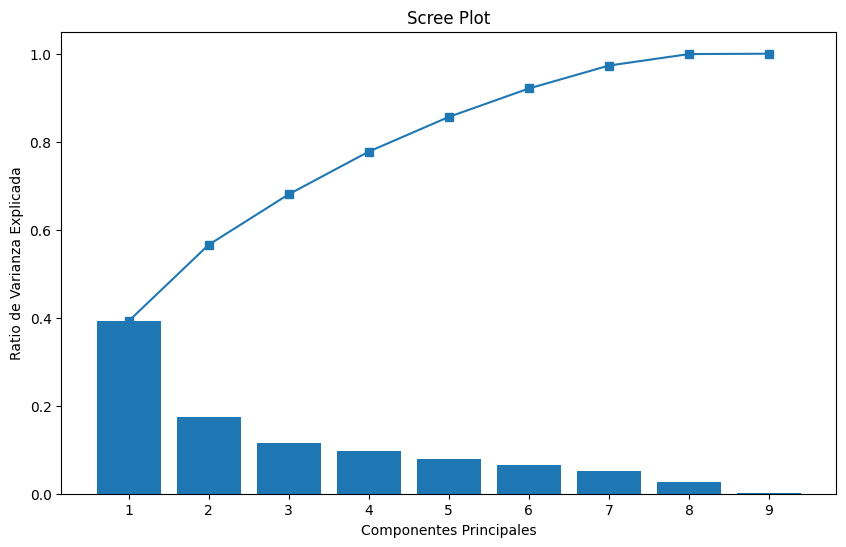

In [24]:
# Se grafica la varianza predicha acorde al número de predictores
plt.figure(figsize=(10, 6))
plt.bar(range(1, X_pca.shape[1] + 1), pca.explained_variance_ratio_)
plt.plot(range(1, X_pca.shape[1] + 1), np.cumsum(pca.explained_variance_ratio_), marker="s")
plt.xticks(range(1, X_pca.shape[1] + 1))
plt.title("Scree Plot")
plt.xlabel("Componentes Principales")
plt.ylabel("Ratio de Varianza Explicada")
plt.show()

In [25]:
# Se arma una tabla con la varianza predicha y el número de predictores
Var = pd.DataFrame({'Variables': range(1, X_pca.shape[1] + 1),
                   'Varianza': np.cumsum(pca.explained_variance_ratio_)})
print(Var)

   Variables  Varianza
0          1  0.392060
1          2  0.565609
2          3  0.680415
3          4  0.777467
4          5  0.856313
5          6  0.920980
6          7  0.973094
7          8  0.999224
8          9  1.000000


(b)

In [26]:
# d) Prediction
# Se observó que el mejor modelo es obtenido por el FWD
matches_to_predict = [
    ("Leicester City", "Everton"),
    ("Arsenal", "Chelsea"),
    ("Liverpool", "Fulham"),
    ("Man City", "West Ham"),
    ("Brighton", "Man United"),
]

Predict = df_fin3[df_fin3['Pred']==1]
Predict = Predict.dropna(axis=1)

target = 'FTR'

X_pred = Predict[['FH','FA', 'Ma6_AR/AF', 'Ma6_AC', 'Ma_TGAEA', 'Ma6_AST', 
             'Ma1_FTHG/HS', 'Ma_RA', 'Ma1_AvgH']]

y_pred = Predict[target]

scale = StandardScaler()
X_pred_log = pd.DataFrame(scale.fit_transform(X_pred),columns =X_pred.columns)

X_pred_pca = pca.fit_transform(X_pred_log)

# Se aplica PCR con 5 componentes
pcr = LogisticRegression()
pcr.fit(X_pca[:, :5], y)
predictions = pcr.predict(X_pred_pca[:, :5])

# Convert the binary predictions back to the original labels (H or A)
predicted_labels = ['H' if prediction == 1 else 'A' for prediction in predictions]

# Print the predicted outcomes
for match, outcome in zip(matches_to_predict, predicted_labels):
    home_team, away_team = match
    print(f"{home_team} vs {away_team}: {outcome}")

Leicester City vs Everton: A
Arsenal vs Chelsea: H
Liverpool vs Fulham: A
Man City vs West Ham: A
Brighton vs Man United: H
